# **1. Custom Functions**

In [27]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
# ONLY ADDED NUMPY AND MATPLOTIB SO I CAN SHOW CONFUSION MATRIX AS A PLOT

# **2. Data Loading Functions**

# *2.1 Load Embeddings and Vocabulary*

In [28]:
def load_embeddings(file_name):
    embeddings = {}
    with open(file_name, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            idx = int(parts[0])
            vector = [float(v) for v in parts[1:]]
            embeddings[idx] = vector
    return embeddings

def load_vocab(file_name):
    vocab = {}
    with open(file_name, 'r', encoding='utf-8') as f:
        for line in f:
            word, idx = line.strip().split()
            vocab[word] = int(idx)
    return vocab

# *2.2 Load Tokenized Texts and Labels*

In [29]:
def load_list(file_name):
    data_list = []
    with open(file_name, 'r', encoding='utf-8') as f:
        for line in f:
            data_list.append(line.strip().split())
    return data_list

def load_labels(file_name):
    labels = []
    with open(file_name, 'r', encoding='utf-8') as f:
        for line in f:
            labels.append(int(line.strip()))
    return labels

# **3. Neural Network Functions**

# *3.1 Initialize Parameters*

In [30]:
def initialize_parameters(input_size, hidden_node_size1, hidden_node_size2, output_size):
    W1 = np.random.uniform(-0.5, 0.5, (input_size, hidden_node_size1))
    b1 = np.zeros((hidden_node_size1,))
    W2 = np.random.uniform(-0.5, 0.5, (hidden_node_size1, hidden_node_size2))
    b2 = np.zeros((hidden_node_size2,))
    W3 = np.random.uniform(-0.5, 0.5, (hidden_node_size2, output_size))
    b3 = np.zeros((output_size,))
    return W1, b1, W2, b2, W3, b3

# *3.2 Forward Pass*

In [31]:
def forward_pass(X, W1, b1, W2, b2, W3, b3, dropout_rate=0.0):
    Z1 = np.dot(X, W1) + b1
    A1 = np.tanh(Z1)
    A1 *= np.random.binomial(1, 1 - dropout_rate, size=A1.shape)
    Z2 = np.dot(A1, W2) + b2
    A2 = np.tanh(Z2)
    A2 *= np.random.binomial(1, 1 - dropout_rate, size=A2.shape)
    Z3 = np.dot(A2, W3) + b3
    A3 = 1 / (1 + np.exp(-Z3))
    return Z1, A1, Z2, A2, Z3, A3

# *3.3 Backward Pass*

In [32]:
def backward_pass(X, y, Z1, A1, Z2, A2, Z3, A3, W2, W3):
    dZ3 = A3 - y
    dW3 = np.dot(A2.reshape(-1,1), dZ3.reshape(1,-1))
    db3 = dZ3
    dA2 = np.dot(W3, dZ3)
    dZ2 = dA2 * (1 - np.tanh(Z2)**2)
    dW2 = np.dot(A1.reshape(-1,1), dZ2.reshape(1,-1))
    db2 = dZ2
    dA1 = np.dot(W2, dZ2)
    dZ1 = dA1 * (1 - np.tanh(Z1)**2)
    dW1 = np.dot(X.reshape(-1,1), dZ1.reshape(1,-1))
    db1 = dZ1
    return dW1, db1, dW2, db2, dW3, db3

# *3.4 Updating Parameters*

In [33]:
def update_parameters(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, learning_rate, l2_lambda):
    W1 -= learning_rate * (dW1 + l2_lambda * W1)
    b1 -= learning_rate * db1
    W2 -= learning_rate * (dW2 + l2_lambda * W2)
    b2 -= learning_rate * db2
    W3 -= learning_rate * (dW3 + l2_lambda * W3)
    b3 -= learning_rate * db3
    return W1, b1, W2, b2, W3, b3

# *3.5 Computing Loss Function*

In [34]:
def compute_loss(y_true, y_pred, class_weight):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    loss = - (class_weight * y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

# *3.6 Training Function* 

In [35]:
def train_neural_network(X_train, y_train, input_size, hidden_node_size1, hidden_node_size2, output_size, epochs, learning_rate, dropout_rate=0.0, l2_lambda=0.001):
    W1, b1, W2, b2, W3, b3 = initialize_parameters(input_size, hidden_node_size1, hidden_node_size2, output_size)
    class_weight = 1.5  # Adjust as needed
    for epoch in range(epochs):
        combined = list(zip(X_train, y_train))
        random.shuffle(combined)
        X_train_shuffled, y_train_shuffled = zip(*combined)
        total_loss = 0.0
        for X, y in zip(X_train_shuffled, y_train_shuffled):
            X = np.array(X)
            Z1, A1, Z2, A2, Z3, A3 = forward_pass(X, W1, b1, W2, b2, W3, b3, dropout_rate)
            loss = compute_loss(y, A3, class_weight)
            total_loss += loss
            dW1, db1, dW2, db2, dW3, db3 = backward_pass(X, y, Z1, A1, Z2, A2, Z3, A3, W2, W3)
            W1, b1, W2, b2, W3, b3 = update_parameters(
                W1, b1, W2, b2, W3, b3,
                dW1, db1, dW2, db2, dW3, db3,
                learning_rate, l2_lambda
            )
        print('Epoch', epoch + 1, 'Loss:', total_loss)
    return W1, b1, W2, b2, W3, b3

# *3.7 Prediction Function*

In [36]:
def predict(X, W1, b1, W2, b2, W3, b3, threshold=0.5):
    _, _, _, _, _, A3 = forward_pass(np.array(X), W1, b1, W2, b2, W3, b3)
    prediction = A3[0]
    return 1 if prediction >= threshold else 0

# *3.8 Evaluation Function*

In [37]:
def evaluate_model(X_test, y_test, W1, b1, W2, b2, W3, b3, threshold=0.5):
    TP = FP = TN = FN = 0
    for X, y in zip(X_test, y_test):
        y_pred = predict(X, W1, b1, W2, b2, W3, b3, threshold)
        if y == 1 and y_pred == 1:
            TP += 1
        elif y == 0 and y_pred == 0:
            TN += 1
        elif y == 0 and y_pred == 1:
            FP += 1
        elif y == 1 and y_pred == 0:
            FN += 1
    total = TP + TN + FP + FN
    accuracy = (TP + TN) / total if total != 0 else 0.0
    precision = TP / (TP + FP + 1e-7) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN + 1e-7) if (TP + FN) != 0 else 0.0
    f1_score = 2 * precision * recall / (precision + recall + 1e-7) if (precision + recall) != 0 else 0.0
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1_score)
    return np.array([[TP, FN],
                     [FP, TN]])

# **4. Data Preparation and Training**

# *4.1 Set Parameters*

In [44]:
embedding_dim = 10  # Should match the embedding dimension used in Word2Vec
input_size = 12 * embedding_dim  # 120
hidden_node_size1 = 2  # Adjusted hidden layer size
hidden_node_size2 = 8   # Second hidden layer size
output_size = 1
epochs = 100  # Number of epochs
learning_rate = 0.003
dropout_rate = 0.2
l2_lambda = 0.001

# *4.2 Load Data*

In [45]:
word_embeddings = load_embeddings('word_embeddings.txt')
vocab = load_vocab('vocab.txt')
tokenized_texts = load_list('tokenized_texts.txt')
labels = load_labels('labels.txt')

# *4.3 Vectorize Texts*

In [46]:
def vectorize_texts(tokenized_texts, vocab, word_embeddings, max_words=12):
    vectorized_texts = []
    for words in tokenized_texts:
        words = words[:max_words]
        while len(words) < max_words:
            words.append('<PAD>')
        vector = []
        for word in words:
            if word in vocab:
                idx = vocab[word]
                vector.extend(word_embeddings[idx])
            else:
                vector.extend([0.0] * embedding_dim)
        vectorized_texts.append(vector)
    return vectorized_texts

X = vectorize_texts(tokenized_texts, vocab, word_embeddings)
y = labels

# *4.4 Split Data into Training and Testing Sets*

In [47]:
def train_test_split(X, y, test_size=0.2):
    combined = list(zip(X, y))
    random.shuffle(combined)
    split_idx = int(len(combined) * (1 - test_size))
    train_data = combined[:split_idx]
    test_data = combined[split_idx:]
    X_train, y_train = zip(*train_data)
    X_test, y_test = zip(*test_data)
    return list(X_train), list(y_train), list(X_test), list(y_test)

X_train, y_train, X_test, y_test = train_test_split(X, y)

# *4.5 Train the Neural Network*

In [48]:
W1, b1, W2, b2, W3, b3 = train_neural_network(
    X_train, y_train, input_size, hidden_node_size1, hidden_node_size2, output_size,
    epochs, learning_rate, dropout_rate, l2_lambda
)

Epoch 1 Loss: [687.06734604]
Epoch 2 Loss: [679.17807876]
Epoch 3 Loss: [678.87192985]
Epoch 4 Loss: [668.36783518]
Epoch 5 Loss: [658.13657413]
Epoch 6 Loss: [653.12709438]
Epoch 7 Loss: [647.62185026]
Epoch 8 Loss: [632.58223935]
Epoch 9 Loss: [639.93993583]
Epoch 10 Loss: [623.79055956]
Epoch 11 Loss: [606.35178486]
Epoch 12 Loss: [587.34904105]
Epoch 13 Loss: [585.24219235]
Epoch 14 Loss: [566.13112411]
Epoch 15 Loss: [584.27779754]
Epoch 16 Loss: [557.05094806]
Epoch 17 Loss: [551.17974486]
Epoch 18 Loss: [526.87658286]
Epoch 19 Loss: [527.97558655]
Epoch 20 Loss: [526.35393687]
Epoch 21 Loss: [504.12357172]
Epoch 22 Loss: [489.12708272]
Epoch 23 Loss: [472.07113258]
Epoch 24 Loss: [486.10110312]
Epoch 25 Loss: [467.65756455]
Epoch 26 Loss: [458.21749827]
Epoch 27 Loss: [443.70513323]
Epoch 28 Loss: [451.17736238]
Epoch 29 Loss: [442.97905932]
Epoch 30 Loss: [429.66672214]
Epoch 31 Loss: [449.80774925]
Epoch 32 Loss: [415.20200006]
Epoch 33 Loss: [433.34261583]
Epoch 34 Loss: [422

# **5. Evaluate the Model**

In [49]:
confusion_matrix = evaluate_model(X_test, y_test, W1, b1, W2, b2, W3, b3, threshold=0.5)

Accuracy: 0.845
Precision: 0.8350515455308748
Recall: 0.8437499991210938
F1 Score: 0.8393781874734922


# **6. Visualization Of Confusion Matrix**

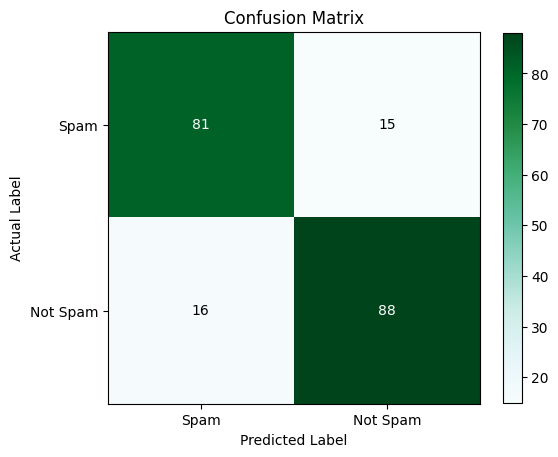

In [50]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.BuGn):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

class_names = ['Spam', 'Not Spam']
plot_confusion_matrix(confusion_matrix, classes=class_names)